In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [2]:
df = pd.read_csv("E:\\AppliedAI\\Quora\\nlp_features_train.csv",encoding='latin-1')
df.fillna('')
df.head()   

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [3]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s', encoding='utf-8')

np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s', encoding='utf-8')



Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [4]:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110303
Total number of words in non duplicate pair questions : 33194892


Word Cloud for Duplicate Question pairs


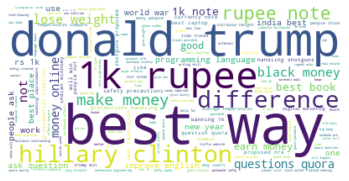

In [5]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non Duplicate Question pairs


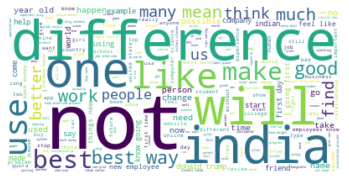

In [7]:
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)
print ("Word Cloud for non Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

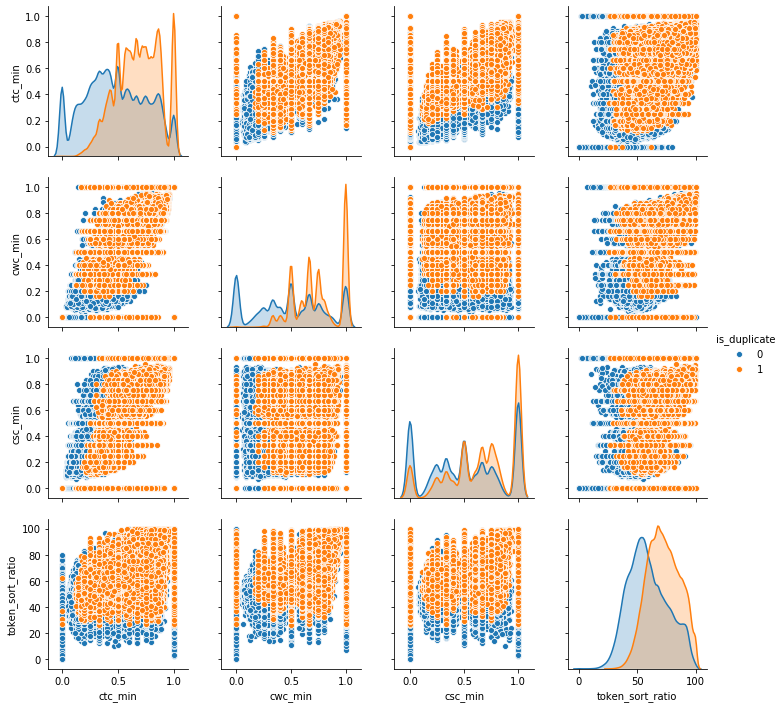

In [8]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

In [9]:
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:20000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [10]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.186s...
[t-SNE] Computed neighbors for 20000 samples in 2.415s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sam

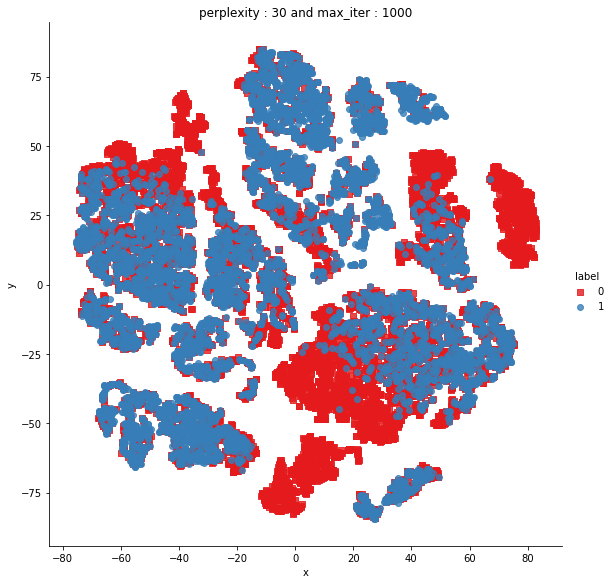

In [13]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [15]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.176s...
[t-SNE] Computed neighbors for 20000 samples in 2.478s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sam

In [17]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')